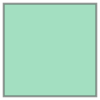

In [39]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import patches
import matplotlib as mpl
# from descartes import PolygonPatch
import shapely
import geopandas as gpd

import pandas as pd

# exteriors CCW
# interior (rings) CW

dim = 3
offset = 1

sq_origin = np.array([0,0])
sq = shapely.geometry.Polygon(np.array([
  sq_origin,
  sq_origin + np.array([dim,   0]),
  sq_origin + np.array([dim, dim]),
  sq_origin + np.array([  0, dim]),
  sq_origin
]))
sq

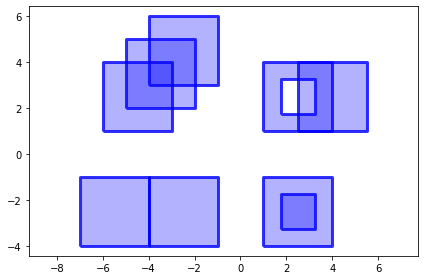

In [24]:
# Three diagonally offset overlapping squares
diag_sq_origin = [-6, 1]
diag_sqs = [
  shapely.affinity.translate(
    sq,
    xoff = offset*i + diag_sq_origin[0],
    yoff = offset*i + diag_sq_origin[1],
    zoff = 0.0)
  for i in range(3)
]

# Square with hole
sq_w_hole_origin = [1,1]
sq_w_hole = shapely.affinity.translate(
  shapely.geometry.Polygon(
    shell = sq.exterior,
    holes = [
      shapely.affinity.scale(
        sq, xfact=0.5, yfact=0.5, zfact=1.0, origin='center'
      ).exterior
    ]
  ),
  xoff = sq_w_hole_origin[0],
  yoff = sq_w_hole_origin[1],
  zoff = 0.0
# use buffer to correct hole orientation (CCW/CW)
).buffer(0.0)

# Square overlapping square with holes
# Offset on x-axis
sq_w_hole_friend = shapely.affinity.translate(
  sq,
  xoff = sq_w_hole_origin[0] + dim/2,
  yoff = sq_w_hole_origin[1],
  zoff = 0.0
)

# Square containing smaller square
sq_containing_origin = [1, -1 - dim]
sq_contained_origin  = [1.75, -1.75 - dim/2]
sq_containing = shapely.affinity.translate(
  sq,
  xoff = sq_containing_origin[0],
  yoff = sq_containing_origin[1],
  zoff = 0.0)
sq_contained = shapely.affinity.translate(
  shapely.geometry.Polygon(
    shapely.affinity.scale(
      sq, xfact=0.5, yfact=0.5, zfact=1.0, origin=(0,0,0)
    ).exterior
  ),
  xoff = sq_contained_origin[0],
  yoff = sq_contained_origin[1],
  zoff = 0.0)

# Two squares touching at boundary
touching_sq_origin = [-1 - dim, -1 - dim]
touching_sqs = [
  shapely.affinity.translate(
    sq,
    xoff = touching_sq_origin[0] - dim*i,
    yoff = touching_sq_origin[1],
    zoff = 0.0)
  for i in range(2)
]


shapes = [sq_w_hole, sq_w_hole_friend, sq_containing, sq_contained]
shapes.extend(diag_sqs)
shapes.extend(touching_sqs)

fig, ax = plt.subplots()

gpd.GeoSeries(shapes).plot(
  ax=ax,
  facecolor=(0, 0, 1, 0.3),
  edgecolor=(0, 0, 1, 0.8),
  linewidth = 3
)

ax.axis('equal')
fig.tight_layout()

plt.show()

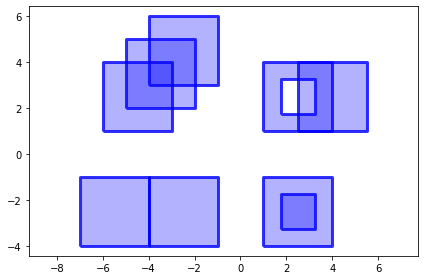

In [27]:
shapes = [
  ('sq_w_hole', sq_w_hole),
  ('sq_w_hole_friend', sq_w_hole_friend),
  ('sq_containing', sq_containing),
  ('sq_contained', sq_contained)
]
shapes.extend([(f'diag_sq_{i}', diag_sqs[i]) for i in range(len(diag_sqs))])
shapes.extend([(f'touching_sq_{i}', touching_sqs[i]) for i in range(len(touching_sqs))])

d = {
  'name': [shape[0] for shape in shapes],
  'geometry': [shape[1] for shape in shapes]
}

gdf = gpd.GeoDataFrame(d)

fig, ax = plt.subplots()

gdf.plot(
  ax=ax,
  facecolor=(0, 0, 1, 0.3),
  edgecolor=(0, 0, 1, 0.8),
  linewidth = 3
)

ax.axis('equal')
fig.tight_layout()

plt.show()

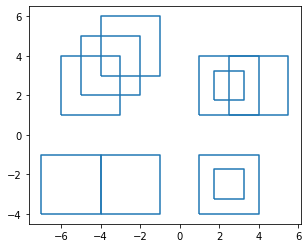

In [64]:
boundaries_gser = gdf['geometry'].boundary.explode(index_parts=False).rename('boundary')
boundaries_gser.plot()
plt.show()

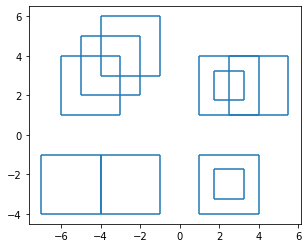

In [67]:
def decompose_ls(ls):
  return list(map(shapely.geometry.LineString, zip(ls.coords[:-1], ls.coords[1:])))

segments_gser = gpd.GeoSeries(data = boundaries_gser.apply(decompose_ls).explode())
segments_gser.plot()
plt.show()

In [68]:
print(len(segments_gser))

segments_gser = segments_gser.drop_duplicates()

print(len(segments_gser))

segments_gser = segments_gser.apply(lambda g: g.normalize()).drop_duplicates()

print(len(segments_gser))

40
40
39


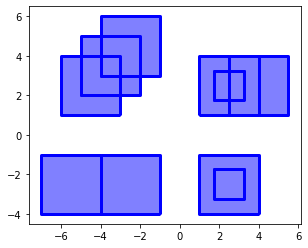

In [77]:
polygonize_segs_gser = gpd.GeoSeries(shapely.ops.polygonize(segments_gser.unary_union))

polygonize_segs_gser.plot(
  facecolor=(0.5, 0.5, 1, 1),
  edgecolor=(0, 0, 1, 1),
  linewidth = 3
)
plt.show()

In [78]:
len(polygonize_segs_gser)

16

In [80]:
len(gpd.GeoSeries(shapely.ops.polygonize(boundaries_gser.unary_union)))

16